Short notebook to load and visualize a cloud point after generation (voxelized with voxels of size 10cm) 

In [239]:
from utils_notebook import *

In [240]:
CLOUD_POINT_PATH = "cloud_filtered_currentBest.ply"

In [282]:
pts_vox, cols_vox = load_and_decimate_room_pc_voxels(CLOUD_POINT_PATH)
point_cloud_visu(pts_vox, cols_vox)

In [242]:
pts = filter_by_height(pts_vox, min_height=0.5,max_height = 4)

In [243]:
filtered_pts = filter_by_distance(pts, distance_threshold=0.1)

In [244]:
# Projection
#taille = compute_cell_size(filtered_pts)
grille_2D = project_to_grid(filtered_pts,cell_size=0.1)

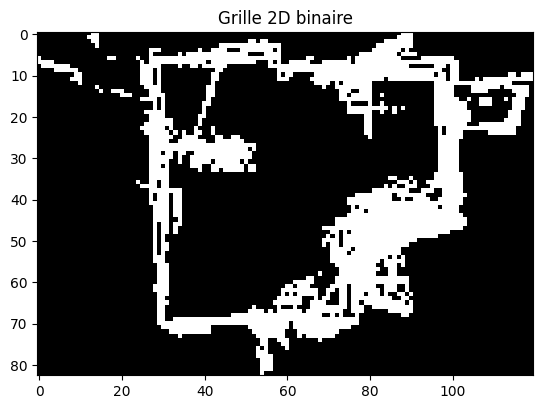

In [245]:
# Visualisation pour vérifier
plt.imshow(grille_2D, cmap='gray')
plt.title('Grille 2D binaire')
plt.show()

In [246]:
import cv2

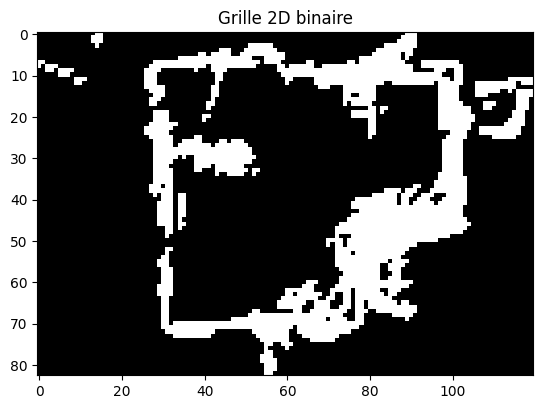

In [247]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2))
opened = cv2.morphologyEx(grille_2D, cv2.MORPH_OPEN, kernel)

# Visualisation pour vérifier
plt.imshow(opened, cmap='gray')
plt.title('Grille 2D binaire')
plt.show()

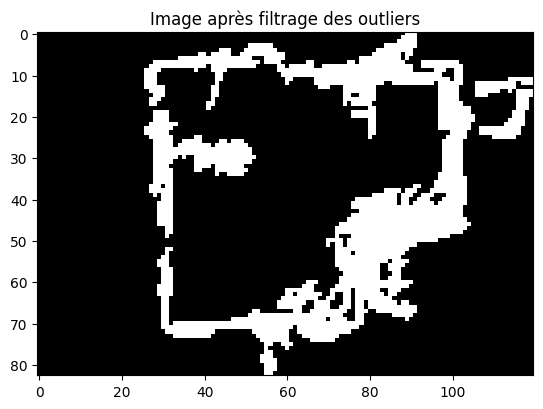

In [294]:
# Filtrer les outliers sur l'image d'ouverture
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)

# Créer une nouvelle image pour stocker les objets filtrés
filtered_image = np.zeros_like(opened)

# Définir un seuil de taille minimale pour les objets
min_size = 50  # Par exemple, 50 pixels

# Parcourir les composants connectés et conserver ceux qui dépassent le seuil
for i in range(1, num_labels):  # Ignorer le label 0 (fond)
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        filtered_image[labels == i] = 255

# Visualisation pour vérifier
plt.imshow(filtered_image, cmap='gray')
plt.title('Image après filtrage des outliers')
plt.show()

Aire (en pixels blancs): 1956


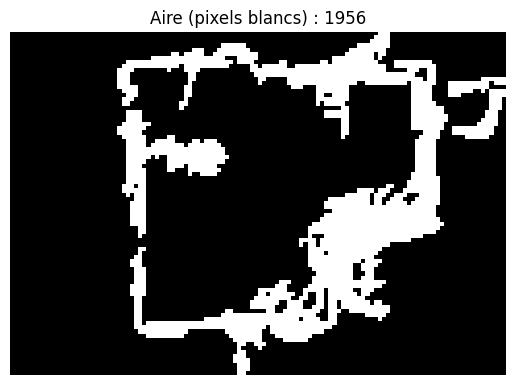

In [295]:
# Remplace 'image_cartographie.png' par le chemin de ton image
_, binary = cv2.threshold(filtered_image, 127, 255, cv2.THRESH_BINARY)

# === 2. Remplissage des trous internes ===
# Inverser l’image
inv = cv2.bitwise_not(binary)

# Préparer le masque pour floodFill
h, w = inv.shape
mask = np.zeros((h + 2, w + 2), np.uint8)

# Appliquer floodFill depuis le bord
flood_filled = inv.copy()
cv2.floodFill(flood_filled, mask, seedPoint=(0, 0), newVal=255)

# Inverser pour retrouver les zones intérieures
flood_filled_inv = cv2.bitwise_not(flood_filled)

# Combiner avec l'image binaire originale
filled_image = cv2.bitwise_or(binary, flood_filled_inv)

# === 3. Calcul de l’aire ===
area_pixels = cv2.countNonZero(filled_image)
print("Aire (en pixels blancs):", area_pixels)

# === 4. Affichage ===
plt.imshow(filled_image, cmap='gray')
plt.title(f"Aire (pixels blancs) : {area_pixels}")
plt.axis('off')
plt.show()


In [296]:
import cv2
import numpy as np

# 'image' doit être uint8 (0 et 255)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filled_image, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
largest_cc = (labels == largest_label).astype(np.uint8) * 255

print(largest_cc)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [297]:
objects_list = extract_largest_objects_from_voxels_km(pts_vox,n_clusters=50)

In [298]:
print(len(objects_list))

50


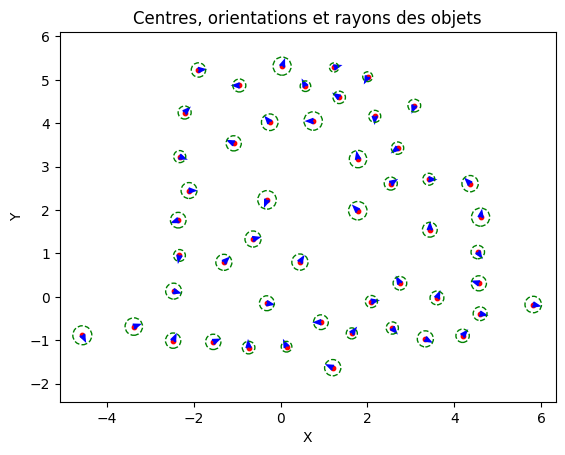

In [299]:
# Extraire et visualiser les centres, orientations et rayons des objets
centers = [obj['center'] for obj in objects_list]
orientations = [obj['orientation'] for obj in objects_list]  # Supposons que l'orientation est un angle en radians
radii = [obj['radius'] for obj in objects_list]  # Supposons que chaque objet a un rayon défini

# Visualisation des centres des objets
plt.scatter([center[0] for center in centers], [center[1] for center in centers], c='red', s=10)

# Ajouter les flèches pour représenter l'orientation
for center, orientation, radius in zip(centers, orientations, radii):
    dx = 0.2 * np.cos(orientation)  # Longueur réduite de la flèche en X
    dy = 0.2 * np.sin(orientation)  # Longueur réduite de la flèche en Y
    plt.quiver(center[0], center[1], dx, dy, angles='xy', scale_units='xy', scale=1, color='blue', 
               headwidth=3, headlength=4)  # Réduction de la taille de la pointe

    # Ajouter un cercle pour représenter le rayon
    circle = plt.Circle(center, 0.2*radius, color='green', fill=False, linestyle='--')  # Cercle en pointillés
    plt.gca().add_artist(circle)

plt.title('Centres, orientations et rayons des objets')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

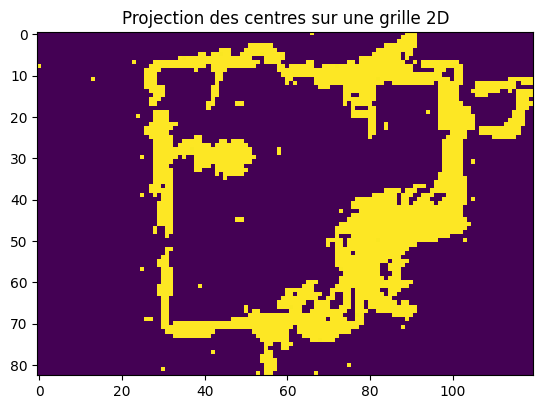

In [300]:
from scipy.ndimage import zoom

# Redimensionnement
zoom_factor = (
    filtered_image.shape[0] / centers_grid.shape[0],
    filtered_image.shape[1] / centers_grid.shape[1]
)
centers_grid_resized = zoom(centers_grid, zoom_factor, order=0)

# Additionnez les matrices et affichez
plt.imshow(clusters_grid := centers_grid_resized + filtered_image)
plt.title('Projection des centres sur une grille 2D')
plt.show()

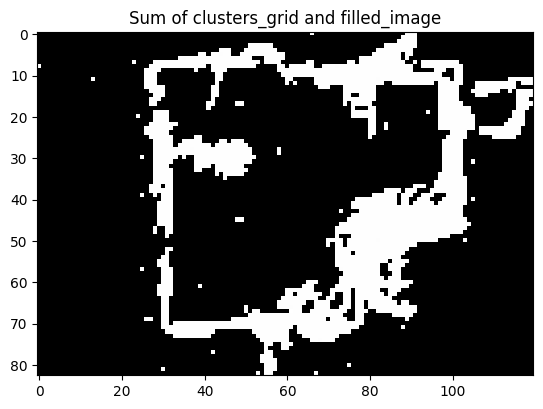

Centres dans la bounding box : []


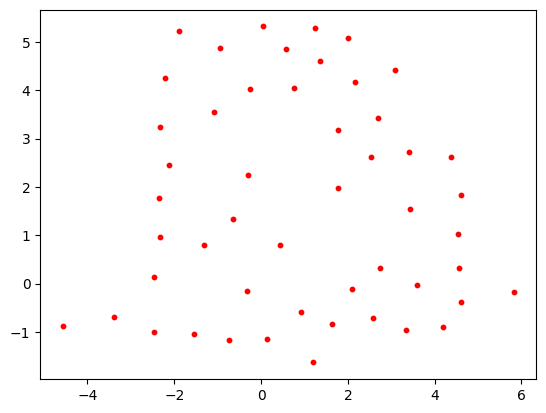

In [301]:
# Sum clusters_grid with another matrix (e.g., filled_image)
result_sum = clusters_grid + filled_image

# Visualize the result
plt.imshow(result_sum, cmap='gray')
plt.title('Sum of clusters_grid and filled_image')
plt.show()
# Visualisation des centres, orientations et rayons
plt.scatter([center[0] for center in centers], [center[1] for center in centers], c='red', s=10)


# 'binary' est ton image binaire (0 et 255)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filled_image, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

# Bounding box
left   = stats[largest_label, cv2.CC_STAT_LEFT]
top    = stats[largest_label, cv2.CC_STAT_TOP]
width  = stats[largest_label, cv2.CC_STAT_WIDTH]
height = stats[largest_label, cv2.CC_STAT_HEIGHT]

# Centroïde
cx, cy = centroids[largest_label]

# Convertir centers en un tableau NumPy
centers = np.array(centers)

# Filtrer les centres dans la bounding box
in_bbox = (
    (centers[:, 0] >= left) &
    (centers[:, 0] < left + width) &
    (centers[:, 1] >= top) &
    (centers[:, 1] < top + height)
)
centres_in_bbox = centers[in_bbox]

# Afficher les centres dans la bounding box
print("Centres dans la bounding box :", centres_in_bbox)

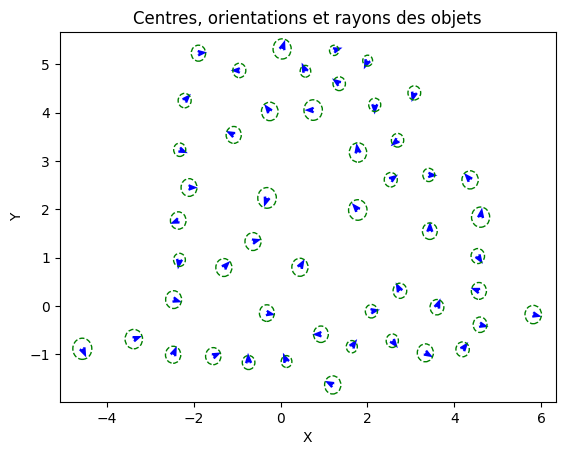

In [302]:
# Ajouter les flèches pour représenter l'orientation
for center, orientation, radius in zip(centers, orientations, radii):
    dx = 0.2 * np.cos(orientation)  # Longueur réduite de la flèche en X
    dy = 0.2 * np.sin(orientation)  # Longueur réduite de la flèche en Y
    plt.quiver(center[0], center[1], dx, dy, angles='xy', scale_units='xy', scale=1, color='blue', 
               headwidth=3, headlength=4)  # Réduction de la taille de la pointe

    # Ajouter un cercle pour représenter le rayon
    circle = plt.Circle(center, 0.2*radius, color='green', fill=False, linestyle='--')  # Cercle en pointillés
    plt.gca().add_artist(circle)

plt.title('Centres, orientations et rayons des objets')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()